Logistic Regression Code: TO INPUT

In [7]:
%load_ext autoreload
%autoreload 2
from logistic2 import SparseKernelLogisticRegression, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Blog Post 6 - Sparse Kernel Machines

# Abstract

In this post, we will explore sparse kernel logistic regression. We implement the model in `logistic2.py` using torch, and conduct experiments tweaking the hyperparameters for this model. We will demonstrate how varying the regularization parameter λ encourages sparsity in the learned model, often requiring only a small subset of training examples to define the decision boundary. We also show how the γ affects the model’s complexity and decision boundary shape. Finally, we use ROC curves to illustrate how poor tuning of γ can lead to overfitting, emphasizing the importance of hyperparameter selection in kernelized models.

# Part B

This function `rbf_kernel` computes the Radial Basis Function (RBF) kernel. I got this code chunk from Phil. This function takes in between two input matrices X_1 and X_2 and measures the similarity between each pair of points from the two sets. The gamma parameter controls the "width" of the function. Essentially, it takes the original input space into a higher-dimensional feature space, enabling the model to learn nonlinear decision boundaries.

In [106]:
import torch
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

First, let's generate and vizualize some linearly-separable-ish data. 

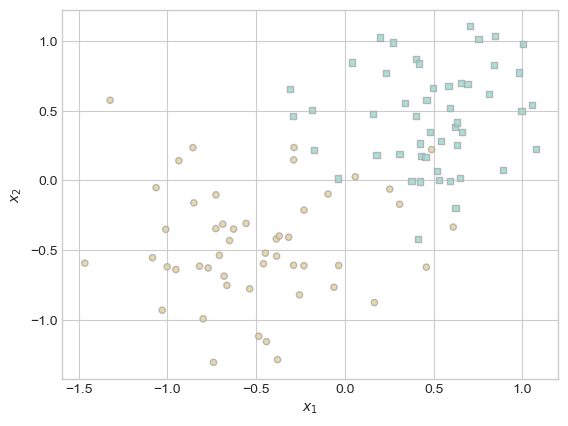

In [107]:
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

Now let's run Sparse Kernal Logistic Regression. Here, we are initializing a SparseKernelLogisticRegression object, passing in our kernel function, along with parameters `lam` and `gamma`. Then, we are fitting the model with 500,000 epochs and a learning rate of 0.0001. 

In [108]:
KR = SparseKernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

In [109]:
(1.0*(KR.a > 0.001)).mean()

tensor(0.0600)

By taking the mean of the weights, we can see that many of the weights are zero because the mean is so small. 

Now let's use Phil's function to visualize the desision boundary that we came up with. Notice here that the non-zero weights are shaded darker. This demonstrates that the model is acting in a way that makes sense because the darker points (ones with non-zero weights) are all very close to the "center" of the general grouping for points of their type. 

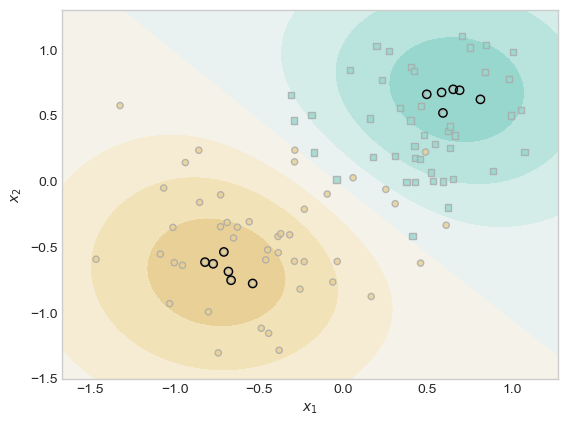

In [110]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

Now, let's see what happens when we make lamda much larger. Here I am setting `lam` to 10, and keeping `gamma` at 1.

In [112]:
KR = SparseKernelLogisticRegression(rbf_kernel, lam=10, gamma=1)
KR.fit(X, y, m_epochs=500000, lr=0.0001)

In [113]:
(1.0*(KR.a > 0.001)).mean()

tensor(0.0100)

After taking the mean of the weights, we can see that very very few of the weights are non-zero. Let's use the same plotting function to see which point this non-zero weight coinsides with. 

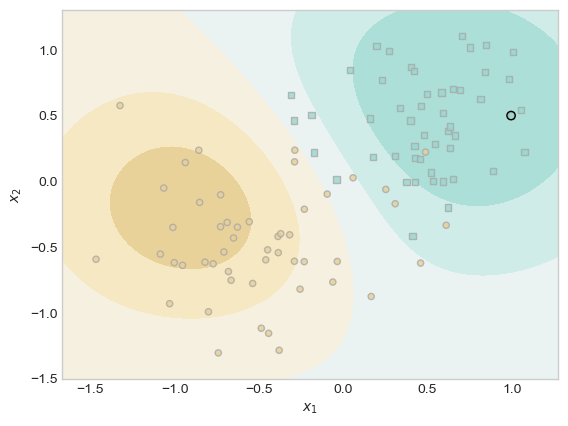

In [114]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

We can see that this model only has one point at (.9, .5) with a non-zero weight. 

Now, let's see what happens when we change the value of gamma. Here we are storing different values of gamma in the `gammas` list and iterating through them. At each step in the loop, we are training a new model with a different choice of gamma, initializing a new Sparse Kernel Model, fitting the points, and visualizing the desision boundary using Phil's function. 

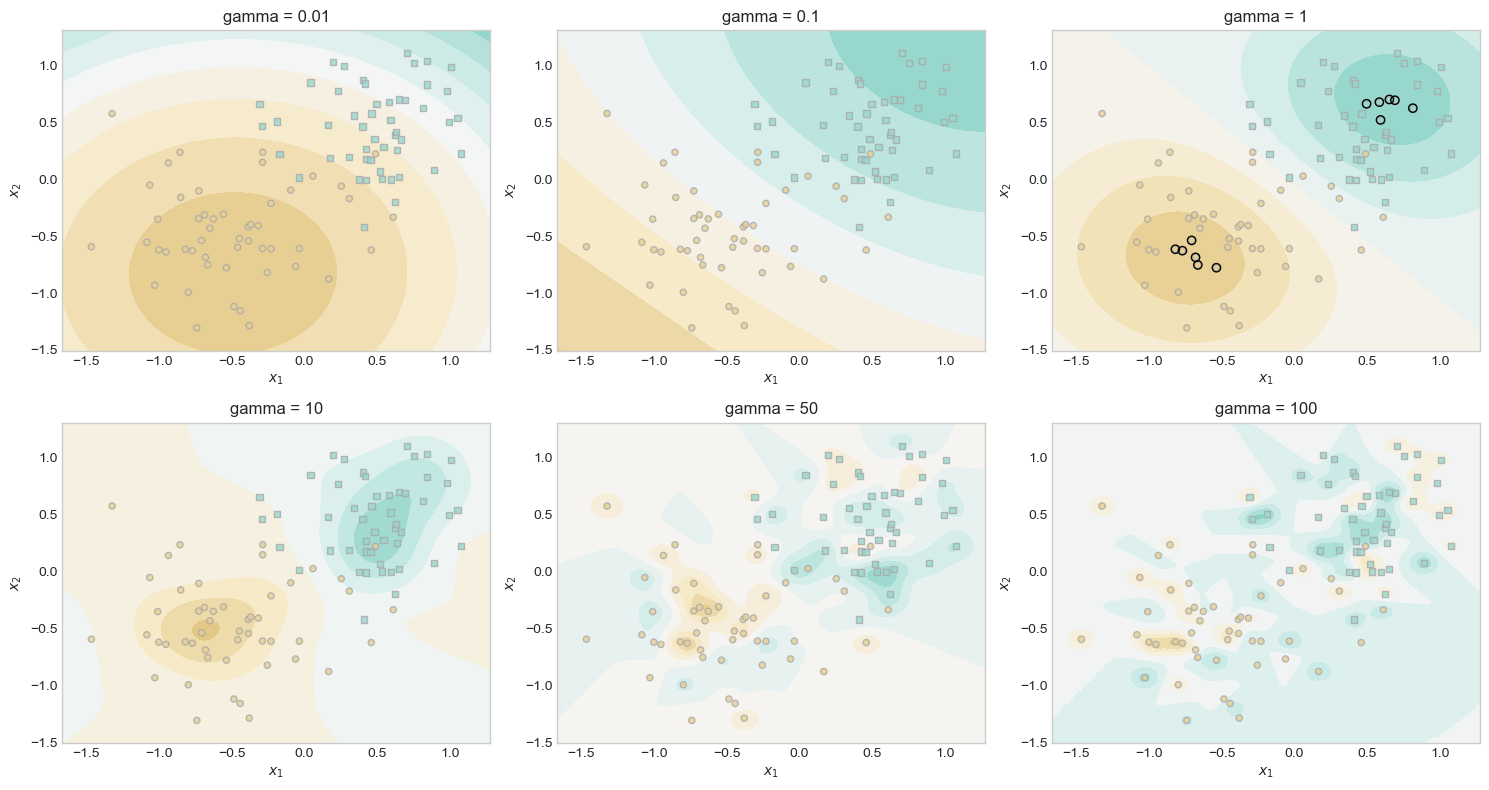

In [115]:
gammas = [0.01, 0.1, 1, 10, 50, 100]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows × 3 columns
axes = axes.flatten()  # So we can index with a single loop

for i, gam in enumerate(gammas):
    KR = SparseKernelLogisticRegression(rbf_kernel, lam=0.1, gamma=gam)
    KR.fit(X, y, m_epochs=500000, lr=0.0001)
    ix = torch.abs(KR.a) > 0.001

    x1 = torch.linspace(X[:, 0].min() - 0.2, X[:, 0].max() + 0.2, 101)
    x2 = torch.linspace(X[:, 1].min() - 0.2, X[:, 1].max() + 0.2, 101)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

    x1 = X1.ravel()
    x2 = X2.ravel()
    X_ = torch.stack((x1, x2), dim=1)

    preds = KR.score(X_)
    preds = 1.0 * torch.reshape(preds, X1.size())

    ax = axes[i]
    ax.contourf(X1, X2, preds, origin="lower", cmap="BrBG",
                vmin=2*preds.min() - preds.max(),
                vmax=2*preds.max() - preds.min())
    plot_classification_data(X, y, ax)
    ax.scatter(X[ix, 0], X[ix, 1], facecolors="none", edgecolors="black")
    ax.set_title(f"gamma = {gam}")

plt.tight_layout()
plt.show()


It is obvious here that as gamma increases, the boundaries get much more wiggly. This is alerting me to the fact that when gamma is large, we are at risk of overfitting. In the gamma = 100 example, the boundaries are very, very, complex. This wouldn't generalize well to unseen testing data. 

Now, let's see how the model performs on non-linear data. Here we are using the sci-kit-learn `make_moons` function. After generating the data, we convert the data to torch tensors so they will work with our model. Then we can see what the points look like on a plot below.

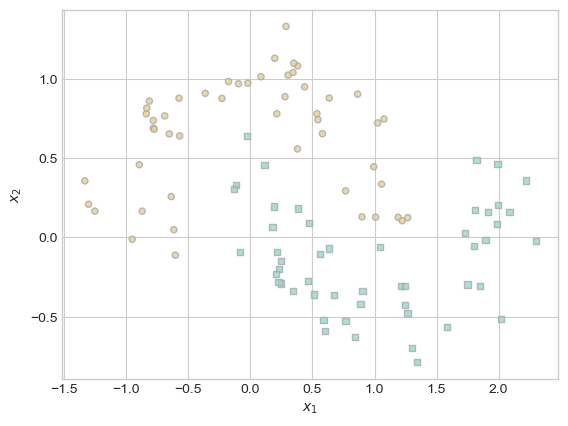

In [125]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
fig, ax = plt.subplots(1, 1)
plot_classification_data(X, y, ax)

From what I have seen in the past two experiments, I decided to use `lam` = .1 and `gamma` = 5. In the two previous experiments, funky things happened when these parameters were large, so I chose some safe values. 

In [129]:
KR = SparseKernelLogisticRegression(rbf_kernel, lam=.1, gamma=5)
KR.fit(X, y, m_epochs=500000, lr=0.0001)

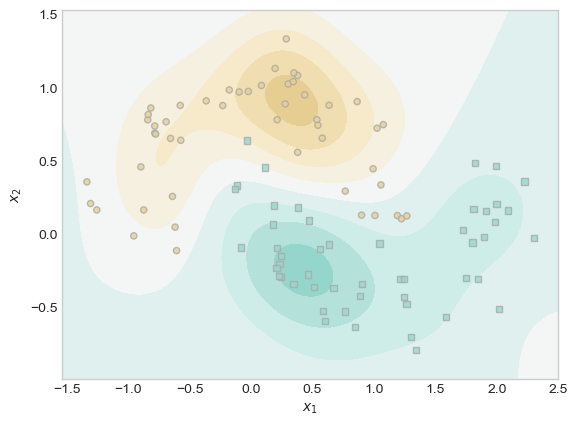

In [131]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

After fitting the model and visualizing the boundaries, it looks like this model was able to correctly catch the moon shapes. Let's quantify how well the model performed. 

In [130]:
y_hat = KR.predict(X)
acc = (y_hat == y).float().mean().item()
print(f"Training Accuracy: {acc:.3f}")

Training Accuracy: 0.930


On the training data, the model performed with 93% accuracy. 

COMMENTARY

# Part C

In this experiement, we are aiming to demonstrate overfitting by changing the gamma values. Below, we generate two independent moon-like shapes using the `make_moons` function from earlier. Again, we convert the data to torch tensors. 

In [143]:
X_train, y_train = make_moons(n_samples=200, noise=0.5)
X_test, y_test = make_moons(n_samples=200, noise=0.5)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

/var/folders/3p/_jcm4hhd7rj59x0q1n5_8yrw0000gn/T/ipykernel_10973/1084629014.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Here we are fitting two different models. One with a moderate gamma (1) and one with a high gamma (100). 

In [144]:
model_good = SparseKernelLogisticRegression(rbf_kernel, lam=0.5, gamma=1)
model_overfit = SparseKernelLogisticRegression(rbf_kernel, lam=0.5, gamma=100)

model_good.fit(X_train, y_train, m_epochs=500000, lr=0.01)
model_overfit.fit(X_train, y_train, m_epochs=500000, lr=0.01)

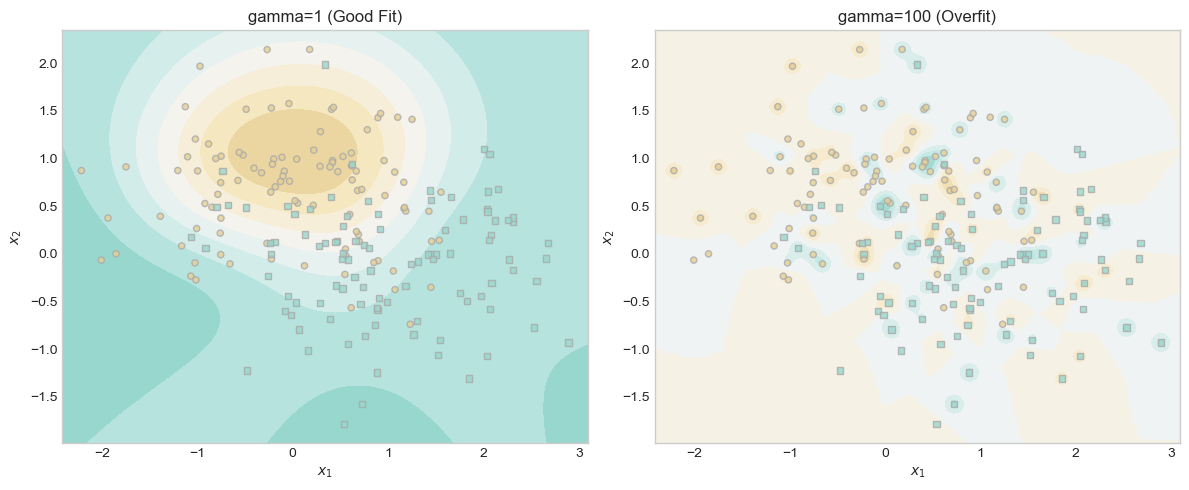

In [147]:
import matplotlib.pyplot as plt
import torch

# Compute important values for the grid
x1 = torch.linspace(X_train[:,0].min() - 0.2, X_train[:,0].max() + 0.2, 101)
x2 = torch.linspace(X_train[:,1].min() - 0.2, X_train[:,1].max() + 0.2, 101)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
x1 = X1.ravel()
x2 = X2.ravel()
X_ = torch.stack((x1, x2), dim=1)

# Compute scores
preds_good = model_good.score(X_).reshape(X1.size())
preds_overfit = model_overfit.score(X_).reshape(X1.size())

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Good model
axes[0].contourf(X1, X2, preds_good, origin="lower", cmap="BrBG", 
                 vmin=2*preds_good.min() - preds_good.max(), 
                 vmax=2*preds_good.max() - preds_good.min())
plot_classification_data(X_train, y_train, axes[0])
axes[0].set_title("gamma=1 (Good Fit)")

# Overfit model
axes[1].contourf(X1, X2, preds_overfit, origin="lower", cmap="BrBG", 
                 vmin=2*preds_overfit.min() - preds_overfit.max(), 
                 vmax=2*preds_overfit.max() - preds_overfit.min())
plot_classification_data(X_train, y_train, axes[1])
axes[1].set_title("gamma=100 (Overfit)")

plt.tight_layout()
plt.show()


The decision boundary on the left (γ = 1) captures the general structure of the data well without fitting to noise, while the boundary on the right (γ = 100) is highly irregular and overly complex. This demonstrates overfitting, where the model memorizes the training data at the expense of generalization.

In [145]:
train_scores_good = model_good.score(X_train)
test_scores_good = model_good.score(X_test)

train_scores_overfit = model_overfit.score(X_train)
test_scores_overfit = model_overfit.score(X_test)


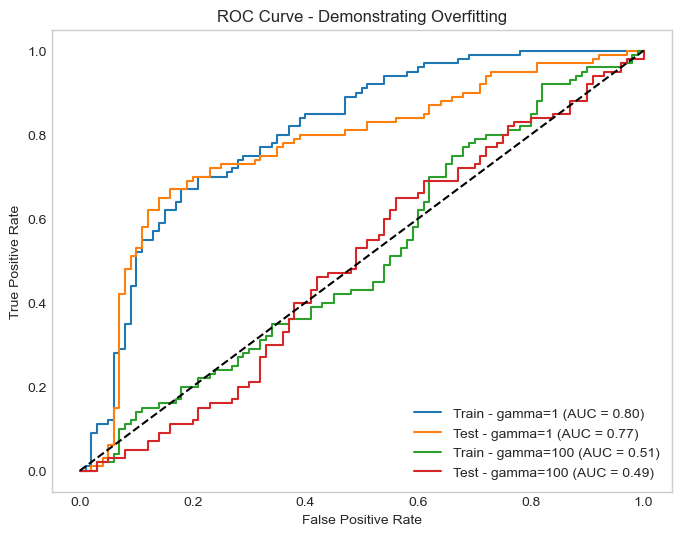

In [148]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, scores, label):
    fpr, tpr, _ = roc_curve(y_true, scores.detach().numpy())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.figure(figsize=(8,6))

# Good model
plot_roc(y_train, train_scores_good, "Train - gamma=1")
plot_roc(y_test, test_scores_good, "Test - gamma=1")

# Overfit model
plot_roc(y_train, train_scores_overfit, "Train - gamma=100")
plot_roc(y_test, test_scores_overfit, "Test - gamma=100")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Demonstrating Overfitting")
plt.legend()
plt.grid()
plt.show()


This ROC curve clearly illustrates overfitting through a comparison of model performance across different values of γ. The dashed line is a benchmark for random guessing the class of a point. When γ = 1, the AUC values for both training (0.80) and testing (0.77) are high and closely aligned, indicating a good fit with strong generalization. In contrast, with γ = 100, the training AUC (0.51) is already low, and the test AUC (0.49) is even worse—approaching random guessing. This drastic drop in performance, especially on unseen data, reveals that the model has overfit to noise in the training set, failing to capture the underlying data pattern in a generalizable way.

# Conclusion

In this blog post, we implemented a sparse kernel logistic regression model using an RBF kernel, allowing us to model nonlinear patterns. We explored how tuning the hyperparameters λ and γ affected model complexity and generalization. Through experiments, we showed that a large λ forces most weights to zero, reducing reliance on unnecessary data points. We also visualized how varying γ shapes the decision boundary and demonstrated how an overly large γ can lead to overfitting. ROC curves further revealed the dangers of overfitting, emphasizing the need to balance model expressiveness with generalization.